# Deep Learning
## HW2


1.   Full Name: Alireza Maleki
2.   Student Number: 401210956

## Problem 1

In [180]:
import torchvision.datasets as tord
import matplotlib.pyplot as plt
import torch as tc
from logging import exception
import numpy as np

# download dataset
ds = tord.FashionMNIST("./", download = True, train = True)


## a. Data Visualization

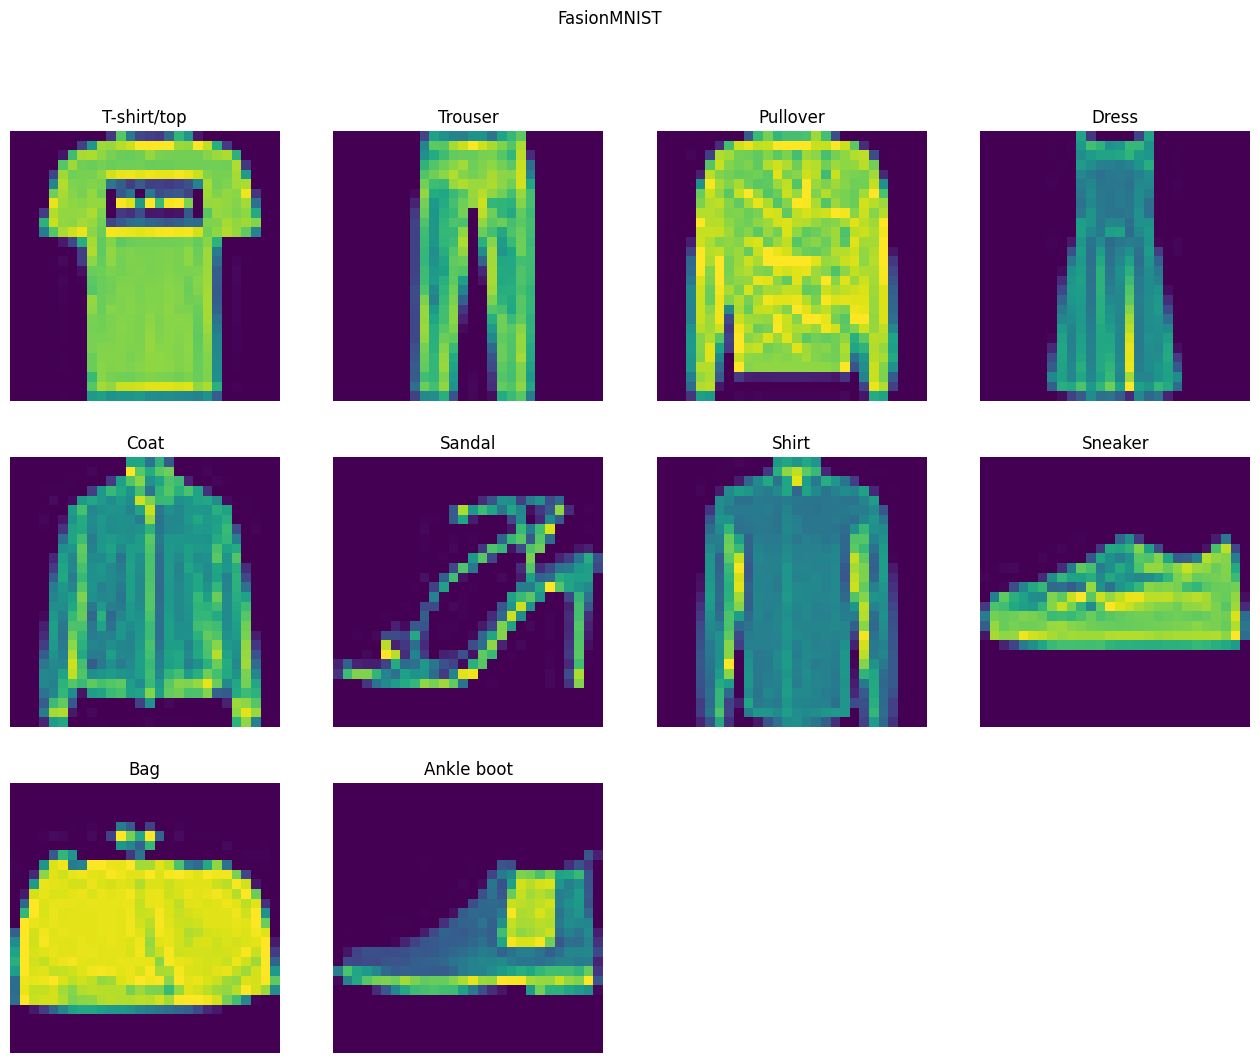

In [181]:
trainSize = ds.train_data.shape

# class label
cls = 0

fig, ax = plt.subplots(3,4);
fig.set_size_inches(16, 12);
fig.suptitle("FasionMNIST")


for i in range(trainSize[0]):

  if ds.train_labels[i] == cls:

      ind2, ind1 = cls % 4, int(cls/4)

      ax[ind1][ind2].imshow(ds.train_data[i]);
      ax[ind1][ind2].axis('off');
      ax[ind1][ind2].set_title(ds.classes[cls]);
      cls = cls+1
  
  if cls==10:
    break

ax[2][3].axis('off');
ax[2][2].axis('off');


---

## b. create NN model

In [182]:
class NNmodel():
  def __init__(self, n, m, l, h, batch, rate):
    if l==0:
      self.W = [np.random.randn(n,m)*.01] # weights
      self.b = [np.random.randn(m)*.01] # biases
    else:
      self.b = [np.random.randn(h)*.01]
      self.W = [np.random.randn(n,h)*.01]
      for _ in range(l-1):
        self.W.append(np.random.randn(h,h)*.01)
        self.b.append(np.random.randn(h)*.01)
      
      self.b.append(np.random.randn(m)*.01)
      self.W.append(np.random.randn(h,m)*.01)
      
    
    self.batch = batch    # batch size
    self.cache = []       # caching layers output
    self.rate = rate      # learning rate
    self.m = m            # # classes
    self.hLayers = l           # number of hidden layers
    self.hNeurons = h          # number of neurons in hidden layer
    
  
  def Softmax(self, X):
    return np.exp(X) / np.sum(np.exp(X),1).reshape((-1,1))

  def normalize(self, X):
    self.avg = np.mean(X,0)
    self.v = np.std(X,0)
    X = (X - self.avg) / self.v
    return X

  def reshape_data(self, X, y):
    l = X.shape[0]
    xSize = X[0].shape[0] * X[0].shape[1]
    X = X.reshape(l, xSize)
    X = tc.tensor(X, dtype=tc.float)
    X = X.numpy()
    yhot = np.zeros((l, self.m))
    for i in range(l):
        yhot[i, y[i]] = 1
    
    return X, yhot

  def ReLU(self, X):
    return X * (X>0) + X * (X<0) * 0.01

  def activate_derivation(self, X, func):
    if func=="relu":
      return (X>0) + (X<0) * 0.01
    elif func=="softmax":
      return X * (1-X)
    else:
      exception("invalid activatio")

  def activate(self, X, W, b, func):
    inputX = np.matmul(X,W) + b
    if func=="softmax":
      return self.Softmax(inputX)
    elif func=="relu":
      return self.ReLU(inputX)
    else:
      exception("invalid activatio")


  def trainNN(self, X, y, activation, epoch):
    
    self.activation = activation
    xSize = X[0].shape[0] * X[0].shape[1]
    X, y = self.reshape_data(X, y)
    X = self.normalize(X)
    Xt, yt, Xv, yv = self.splitData(X, y)
    
    l = Xt.shape[0]
    nBatch = int(l/self.batch)
    for e in range(epoch):
      if e%25==0:
        self.rate = self.rate/2
      shuf = np.random.permutation(l)
      Xt, yt = Xt[shuf], yt[shuf]
    
      for i in range(nBatch):
        ind1, ind2 = i * self.batch, min(l, (i+1) * self.batch)
        Xb = Xt[ind1:ind2]
        yb = yt[ind1:ind2]
        self.cache = [Xb]
        for n in range(self.hLayers):
          Xb = self.activate(Xb, self.W[n], self.b[n], activation)
          self.cache.append(Xb)
            
        Xb = self.activate(Xb, self.W[self.hLayers], self.b[self.hLayers], "softmax")
        self.cache.append(Xb)
        self.backPropagation(yb, activation)
    
      valid = self.feedForward(Xv, activation)
      train = self.feedForward(Xt, activation)
      print("epoch %d - train ce: %.2f, train acc: %.2f, valid ce: %.2f, valid acc: %.2f" % (e,
            self.error_calculator(train, yt), self.accuracy(train, yt), 
            self.error_calculator(valid, yv), self.accuracy(valid, yv)))


  def feedForward(self, Xv, activation):
      for n in range(self.hLayers):
          Xv = self.activate(Xv, self.W[n], self.b[n], activation)
      Xv = self.activate(Xv, self.W[self.hLayers], self.b[self.hLayers], "softmax")
      return Xv
  

  def backPropagation(self, yb, activation):
    
    oj = self.cache.pop()
    delta = (oj - yb) * self.activate_derivation(oj, "softmax")
    delta = delta.T
    oi = self.cache[-1]
    dE = np.matmul(delta, oi) * self.rate / self.batch
    self.W[-1] = self.W[-1] - dE.T
    self.b[-1] = self.b[-1] - np.mean(delta,1) * self.rate

    for l in range(self.hLayers):
      oj = self.cache.pop()
      delta = np.matmul(self.W[-1-l], delta)
      delta = delta * self.activate_derivation(oj, activation).T
      oi = self.cache[-1]
      dE = np.matmul(delta, oi) * self.rate / self.batch
      self.W[-2-l] = self.W[-2-l] - dE.T
      self.b[-2-l] = self.b[-2-l] - np.mean(delta,1) * self.rate
    
    
  def error_calculator(self, o, yb):
      ce = yb * np.log(o) + (1-yb) * np.log(1-o)
      return - ce.sum() / o.shape[0]

  def accuracy(self, o, yb):
    return (np.argmax(o,1) == np.argmax(yb,1)).sum()/ o.shape[0]
    
  def splitData(self, X, y):
    l = X.shape[0]
    lt= int(l*.75)
    return X[:lt], y[:lt], X[lt:], y[lt:]

  def test(self, Xtest, ytest):
    Xtest, ytest = self.reshape_data(Xtest, ytest)
    Xtest = (Xtest - self.avg) / self.v
    yt = self.feedForward(Xtest, self.activation)
    print("test ce: %.2f, test acc: %.2f" % (self.error_calculator(yt, ytest), 
                                                        self.accuracy(yt, yt)))
    
    return np.argmax(yt,1)
    
    



In [186]:
trainSize = ds.train_data.shape
nClass = len(ds.classes)

myModel = NNmodel(trainSize[1]*trainSize[2], nClass, 2, 20, 10, .02)


myModel.trainNN(ds.train_data, ds.train_labels, "relu", 50)



/var/folders/r6/p_jjsz0n7g1c9lrm2vjhgfg80000gn/T/ipykernel_31955/691651328.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = tc.tensor(X, dtype=tc.float)


epoch 0 - train ce: 3.25, train acc: 0.10, valid ce: 3.25, valid acc: 0.10
epoch 1 - train ce: 3.25, train acc: 0.18, valid ce: 3.25, valid acc: 0.18
epoch 2 - train ce: 3.25, train acc: 0.22, valid ce: 3.25, valid acc: 0.22
epoch 3 - train ce: 3.04, train acc: 0.19, valid ce: 3.03, valid acc: 0.19
epoch 4 - train ce: 2.45, train acc: 0.33, valid ce: 2.44, valid acc: 0.34
epoch 5 - train ce: 2.30, train acc: 0.44, valid ce: 2.32, valid acc: 0.45
epoch 6 - train ce: 1.71, train acc: 0.59, valid ce: 1.71, valid acc: 0.59
epoch 7 - train ce: 1.12, train acc: 0.77, valid ce: 1.13, valid acc: 0.77
epoch 8 - train ce: 0.99, train acc: 0.79, valid ce: 1.01, valid acc: 0.79
epoch 9 - train ce: 0.94, train acc: 0.80, valid ce: 0.97, valid acc: 0.79
epoch 10 - train ce: 0.91, train acc: 0.81, valid ce: 0.94, valid acc: 0.81
epoch 11 - train ce: 0.88, train acc: 0.82, valid ce: 0.93, valid acc: 0.81
epoch 12 - train ce: 0.82, train acc: 0.83, valid ce: 0.87, valid acc: 0.82
epoch 13 - train ce: 0

/var/folders/r6/p_jjsz0n7g1c9lrm2vjhgfg80000gn/T/ipykernel_31955/691651328.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = tc.tensor(X, dtype=tc.float)


test ce: 0.74, test acc: 1.00


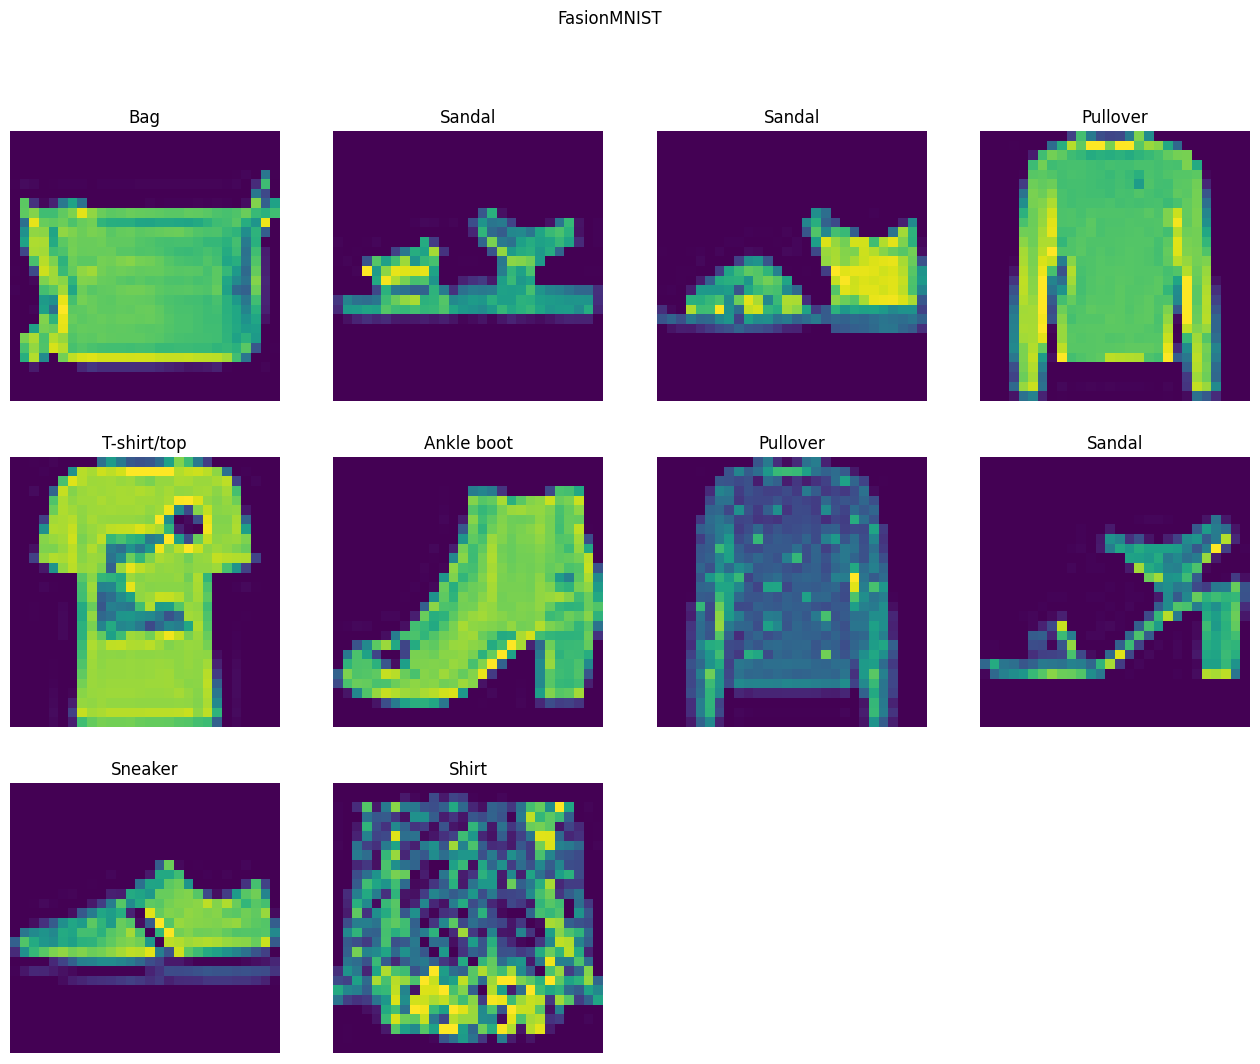

In [185]:
yt = myModel.test(ds.test_data, ds.test_labels)

l = len(ds.test_labels)
shuf = np.random.permutation(l)

Xt = ds.test_data[shuf]
yt = yt[shuf]

fig, ax = plt.subplots(3,4);
fig.set_size_inches(16, 12);
fig.suptitle("FasionMNIST")

for i in range(10):
  ind2, ind1 = i % 4, int(i/4)
  ax[ind1][ind2].imshow(Xt[i]);
  ax[ind1][ind2].axis('off');
  ax[ind1][ind2].set_title(ds.classes[yt[i]]);

ax[2][3].axis('off');
ax[2][2].axis('off');
